<img src="https://github.com/jmcalvomartin/Quantum-Data-Encoding-QML/blob/main/Logo_VIU.png?raw=True" width="300">

## Análisis y estudio del algortimo QSVM con codificacxiónd e datos por amplitud y desplazamiento de fase
### TFM : Codificación de los datos para la aplicación de modelos de Aprendizaje Automático en computación cuántica.
### Anexo 2
#### Autor: Jorge Calvo Martín

### Librerias utilizadas

In [63]:
#Clasical
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import functools

#Quantum
from qiskit import QuantumCircuit, Aer, execute, QuantumRegister
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_bloch_multivector
from qiskit import *
from qiskit.circuit import Parameter, ParameterVector 
from qiskit.circuit.library import ZZFeatureMap , PauliFeatureMap, ZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel 
from qiskit.providers.aer import AerSimulator 
from qiskit_machine_learning.algorithms import QSVC
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123

### Prepararción de los datos

**Descripción del Dataset IRIS:**

El dataset IRIS consta de 150 muestras de flores de iris de tres especies diferentes: Iris setosa, Iris versicolor e Iris virginica. Cada muestra contiene cuatro características: longitud del sépalo, ancho del sépalo, longitud del pétalo y ancho del pétalo, todas medidas en centímetros. El objetivo es clasificar las muestras en una de las tres especies según estas características.

El dataset se divide en tres clases o especies, con 50 muestras de cada una. Esto lo convierte en un conjunto de datos balanceado, lo que es ideal para evaluar algoritmos de clasificación en términos de precisión y rendimiento en diferentes clases. El conjunto de datos IRIS es un ejemplo clásico de un problema de clasificación multiclase, donde se busca predecir una de varias categorías posibles.

**Referencias:**

* Fisher, R. A. (1936). "The use of multiple measurements in taxonomic problems." Annals of Eugenics, 7(2), 179-188. DOI: 10.1111/j.1469-1809.1936.tb02137.x

* Dua, D., & Graff, C. (2019). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science. UCI Machine Learning Repository - Iris Data Set

* Scikit-learn Documentation - Iris Dataset. Scikit-learn Iris Dataset

In [64]:
# Datos clásicos
iris = load_iris()

#x=np.rint(iris.data).astype("int") #Redondeando los valores
#y=np.rint(iris.target).astype("int") #Redondeando los valores

x=iris.data #sin redondear los valores
y=iris.target


#Separar los datos para el entrenamiento
x_tr, x_test, y_tr, y_test = train_test_split(x, y, train_size = 0.8, random_state=algorithm_globals.random_seed)

print("Un dato de ejemplo a transformar de la muestra: ", x_tr[0], y_tr[0])

Un dato de ejemplo a transformar de la muestra:  [7.4 2.8 6.1 1.9] 2


### Visulización de los datos.

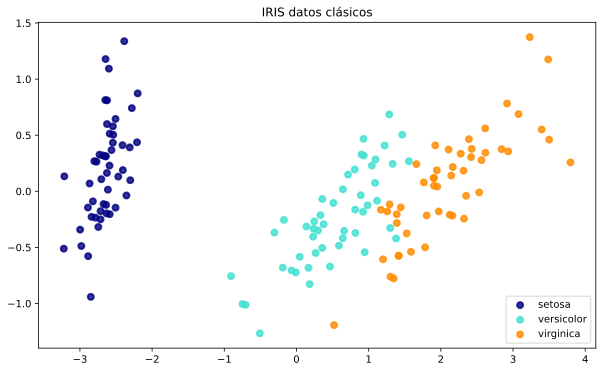

In [65]:
# Aplicar PCA para reducir la dimensión a 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)

# Crear un gráfico de puntos
plt.figure(figsize=(10, 6))
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('IRIS datos clásicos')
plt.show()

## Normalizar
Normalizar todo el conjunto de datos simultáneamente sería, en cierto modo, hacer trampa, porque podríamos estar contaminando el conjunto de datos de entrenamiento con información del conjunto de datos de prueba. Por ejemplo, si tuviéramos un valor atípico en el conjunto de datos de prueba con un valor muy alto en alguna variable, un valor que nunca se alcanzó en el conjunto de datos de entrenamiento, esto se reflejaría en la normalización y, por lo tanto, la independencia de nuestro conjunto de datos de prueba podría ser comprometida.

Ahora que el conjunto de datos de entrenamiento está normalizado, necesitamos normalizar el conjunto de datos de prueba usando las mismas proporciones que el conjunto de datos de entrenamiento. De esta forma, el conjunto de datos de entrenamiento no recibe información sobre el conjunto de datos de prueba. Esto se puede lograr con el siguiente fragmento de código:

In [66]:
scaler = MaxAbsScaler() 
 
x_tr_n = scaler.fit_transform(x_tr)

x_test_n = scaler.transform(x_test) 
 
x_test_n = np.clip(x_test_n,0,1)

print("Un dato de ejemplo a transformar de la muestra: ", x_tr_n[0], y_tr[0])

Un dato de ejemplo a transformar de la muestra:  [0.93670886 0.63636364 0.88405797 0.76      ] 2


## Circuitos parametrizados

Usando circuitos parametrizados, podemos definir cualquier mapa de características de nuestra elección para su uso en un kernel cuántico; por ejemplo, podríamos simplemente enviar cualquiera de los objetos qc que hemos creado en las piezas de código anteriores como el parámetro feature_map en el constructor QuantumKernel. Sin embargo, Qiskit ya viene con algunos mapas de funciones predefinidos listos para usar. Para nuestro caso, podemos generar un circuito para el mapa de características ZZ en 4 qubits utilizando el siguiente código:

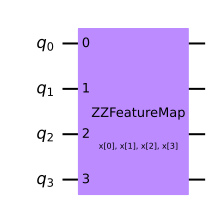

In [67]:
zzfm = ZZFeatureMap(4)
zzfm.draw(output="mpl")

### Ejemplo función de codificación

Esta función **AngleEncodingAmplitude(n)** crea un circuito cuántico con n qubits y aplica una superposición igual de probabilidad a todos los estados. Luego, asigna un ángulo específico a cada estado en la superposición, y finalmente, codifica los ángulos mediante rotaciones controladas en el eje X.

El ejemplo de uso muestra cómo utilizar esta función para crear un mapa de características con 3 qubits, pero puedes cambiar el valor de n para obtener mapas de características con diferentes cantidades de qubits.

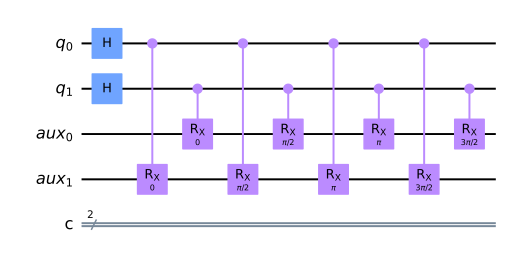

In [68]:
def AngleEncodingAmplitude(n):
    # Creamos un registro cuántico con n qubits
    qreg = QuantumRegister(n, 'q')
    aux_reg = QuantumRegister(n, 'aux')  # Registro auxiliar para las rotaciones controladas
    creg = ClassicalRegister(n, 'c')

    # Creamos un circuito cuántico con los registros cuánticos
    circuit = QuantumCircuit(qreg, aux_reg, creg)

    # Aplicamos una superposición igual de probabilidad a todos los estados
    circuit.h(qreg)

    # Definimos un diccionario para almacenar los ángulos asociados a cada estado
    angles = {}

    # Ángulo base para la codificación de los ángulos
    angle_base = 2 * pi / (2 ** n)

    # Asignamos un ángulo a cada estado en la superposición
    for i in range(2 ** n):
        angle = i * angle_base
        angles[i] = angle

    # Codificamos los ángulos mediante rotaciones controladas en X
    for i in range(2 ** n):
        angle = angles[i]
        for j in range(n):
            circuit.crx(angle, qreg[j], aux_reg[n-j-1])

    # Desechamos los qubits auxiliares
    #circuit.measure(qreg, creg)

    return circuit

# Ejemplo de uso: Mapa de características para 3 qubits
mapa_caracteristicas= AngleEncodingAmplitude(2)
mapa_caracteristicas.draw(output="mpl")

## ZZFeatureMap y PauliFeatureMap Personalizado

* Importe las bibliotecas requeridas de Qiskit.
* Cree una función de mapa de datos personalizada para su mapa de características.
* Cree el FeatureMap personalizado pasando los parámetros del mapa de características y su función de mapa de datos personalizado.
* Cargue el conjunto de datos de Iris y conviértalo al formato requerido para QSVC.
* Defina el clasificador QSVC clásico.
* Entrene el modelo QSVC clásico utilizando los datos de entrenamiento.
* Hacer predicciones sobre los datos de prueba.

### ZZFeatureMap
En este código, definimos la función de mapa de datos personalizados custom_data_map_func(x) para calcular los ángulos de las rotaciones ZZ para el ZZFeatureMap personalizado. Luego creamos el ZZFeatureMap con la función de mapa de datos personalizado y lo aplicamos como el kernel cuántico en el algoritmo QSVC.

### PauliFeatureMap
Para algunas aplicaciones, es posible que deseemos considerar una forma más general del mapa de características. Una forma de generalizar es usar PauliFeatureMap y especificar un conjunto de puertas Pauli en lugar de usar las puertas predeterminadas. Este mapa de funciones tiene los mismos parámetros que ZFeatureMap y ZZFeatureMap, como reps y data_map_function junto con un parámetro paulis adicional para cambiar el conjunto de puertas. Este parámetro es una lista de cadenas, cada una de las cuales representa la(s) puerta(s) Pauli deseada(s). El valor predeterminado es ['Z', 'ZZ'], que es equivalente a ZZFeatureMap.

Cada cadena en paulis se implementa una a la vez para cada capa en el circuito del mapa de características de profundidad. Un solo carácter, por ejemplo, 'Z', agrega una capa de las puertas correspondientes de un solo qubit, mientras que términos como 'ZZ' o 'XY' agregan una capa de las correspondientes puertas entrelazadas de dos qubits para cada par de qubits disponible.

In [89]:
def amplitude_data_map_func(x):

    coeff = functools.reduce(lambda m, n: m + n, (1/np.sqrt(np.sum(np.power(x_tr,2),axis=0)))*x)
    return coeff


def phase_data_map_func(x):

    coeff = functools.reduce(lambda m, n: m * n, np.sin(np.pi-x))
    return coeff

### Funciones de mapeo de datos
Consideramos **M** el número de ejemplos (filas) y **N** cada una de las caracteristicas (columnas)

$ D=x^{1},x^{2},...,x^{m},...,x^{M} $
\
$ x^{m} $ es cada una de las dimensiones del vector para m=1,2,...,M 

#### amplitude_data_map_func: 

$ \alpha = C_{norm} { x^{(1)}_1, \ldots, x^{(1)}_N, x^{(2)}_1, \ldots, x^{(2)}_N, \ldots, x^{(M)}_1, \ldots, x^{(M)}_N } $
\
$ \mathcal{D} \rangle = \sum_{i=1}^{2^n} \alpha_i |i \rangle $


#### phase_data_map_func:
$ \phi_{s}(x) ; S  \subseteq n={1,2....,n} $
\
$ \phi_{s}:x 	\Rightarrow \sin(\pi-x_{i})\sin(\pi-x_{j}); $ if S={i,j}


In [74]:
# Create the custom PauliFeatureMap
reps = 2

#Creamos diferentes mapas de caracteristicas para cada codificación
mapa_caracteristicas_amp = PauliFeatureMap(feature_dimension=2, reps=reps, paulis = ['Z', 'Y'],data_map_func=amplitude_data_map_func)
mapa_caracteristicas_phase = PauliFeatureMap(feature_dimension=4, reps=reps, paulis = ['Z', 'Y', 'ZZ', "XY"],data_map_func=phase_data_map_func)

# Define the backend for simulation
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)

C:\Users\jorge.calvo\AppData\Local\Temp\ipykernel_12056\3050354381.py:10: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024)


### Visualización gráfica del mapa de caracterisitcas 
* PauliFeatureMap para la codificación en amplitud configurada con **2 qubits** 
* PauliFeatureMap para la codificación en desplazamiento de fase configurada con **4 qubits** 

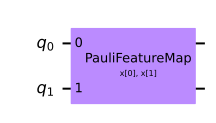

In [75]:
mapa_caracteristicas_amp.draw(output="mpl")

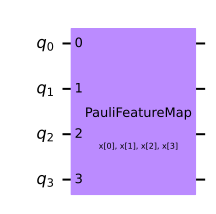

In [76]:
mapa_caracteristicas_phase.draw(output="mpl")

### Resultados de eficacia de ambos modelos.
El entrenamiento de cada modelo se ha realizado con una codificación de datos diferentes
* **qsvm_amp** => entrenado con un mapa de caracteristicas cuyos datos son mapeados con la técnica de amplitud
* **qsvm_phase** => entrenado con un mapa de caracteristicas cuyos datos son mapeados con la técnica de desplazamiento de fase

In [77]:
# Create the QSVC algorithm instance, passing the custom ZZFeatureMap as the quantum kernel

qkernel = QuantumKernel(feature_map = mapa_caracteristicas_amp, quantum_instance = quantum_instance)
qsvm_amp = QSVC(quantum_kernel = qkernel)
qsvm_amp.fit(x_tr, y_tr)
result_amp = qsvm_amp.predict(x_test)
print(f"Eficacia del modelo aplicando codificación de amplitud: {accuracy_score(qsvm_amp.predict(x_test), y_test)}")

Eficacia del modelo aplicando codificación de amplitud: 0.9666666666666667


In [78]:
# Create the QSVC algorithm instance, passing the custom PauliFeatureMap as the quantum kernel

qkernel = QuantumKernel(feature_map = mapa_caracteristicas_phase, quantum_instance = quantum_instance)
qsvm_phase = QSVC(quantum_kernel = qkernel)
qsvm_phase.fit(x_tr, y_tr)
result_phase = qsvm_phase.predict(x_test)
print(f"Eficacia del modelo aplicando codificación de fase: {accuracy_score(qsvm_phase.predict(x_test), y_test)}")

Eficacia del modelo aplicando codificación de fase: 0.8


### Informe de resultados
**Explicación de las métricas utilizadas**

#### Precision:
La precisión es una métrica que evalúa la proporción de instancias positivas que el modelo ha identificado correctamente respecto a todas las instancias que el modelo clasificó como positivas. En otras palabras, mide la proporción de verdaderos positivos (instancias correctamente clasificadas como positivas) con respecto a la suma de verdaderos positivos y falsos positivos (instancias incorrectamente clasificadas como positivas).

**Fórmula:**
\
$ Precisión=\frac{Verdaderos \ Positivos}{Verdaderos \ Positivos+Falsos \ Posittivos} $

#### Recall:
El recall, también conocido como sensibilidad o tasa de verdaderos positivos, evalúa la proporción de instancias positivas que el modelo ha identificado correctamente con respecto a todas las instancias verdaderamente positivas en el conjunto de datos. En otras palabras, mide la proporción de verdaderos positivos con respecto a la suma de verdaderos positivos y falsos negativos (instancias incorrectamente clasificadas como negativas pero que son realmente positivas).

**Fórmula:**
\
$ Recall=\frac{Verdaderos \ Positivos}{Verdaderos \ Positivos+Falsos \ Negativos} $

#### F1-Score:
El F1-score es una métrica que combina la precisión y el recall en una sola medida. Es especialmente útil cuando deseas equilibrar ambas métricas en escenarios donde hay un desequilibrio entre las clases. El F1-score es la media armónica de precisión y recall, lo que significa que da más peso a las métricas que tienen valores bajos.

**Fórmula:**
\
$ F1-Score=2×\frac{Precisión×Recall}{Precisión+Recall} $

#### Support:
El "support" se refiere al número de muestras en cada clase real. Es decir, cuántas instancias pertenecen a cada clase. Esta métrica puede ayudarte a comprender la distribución de las clases en tu conjunto de datos. En la evaluación de modelos, el "support" se utiliza para calcular las métricas de forma ponderada, por ejemplo, en el cálculo del F1-score ponderado.

In [82]:
# Imprimir el classification report
print("Informe de evaluación aplicando codificación de amplitud:")
print(classification_report(y_test, result_amp, target_names=iris.target_names))
print("-------------------------------------------------------------")
print("Informe de evaluación aplicando codificación de amplitud:")
print(classification_report(y_test, result_phase, target_names=iris.target_names))

Informe de evaluación aplicando codificación de amplitud:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       0.86      1.00      0.92         6
   virginica       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30

-------------------------------------------------------------
Informe de evaluación aplicando codificación de amplitud:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       0.50      0.50      0.50         6
   virginica       0.73      0.73      0.73        11

    accuracy                           0.80        30
   macro avg       0.74      0.74      0.74        30
weighted avg       0.80      0.80      0.80        30



### Matriz de confusión
Una matriz de confusión es una herramienta fundamental en el estudio y análisis de modelos de aprendizaje automático, especialmente en tareas de clasificación. Proporciona una visión detallada de cómo un modelo está realizando sus predicciones al comparar las clases reales con las clases predichas por el modelo. En esencia, ayuda a entender cuánto acierto y error tiene el modelo en cada categoría.

Consiste en una tabla que organiza las predicciones del modelo en cuatro categorías:

* **Verdaderos Positivos (True Positives, TP):** Estas son las instancias que el modelo ha clasificado correctamente como positivas. En otras palabras, son las instancias que son positivas en la realidad y que el modelo ha acertado en clasificar como positivas.

* **Falsos Positivos (False Positives, FP):** Estas son las instancias que el modelo ha clasificado incorrectamente como positivas. Son las instancias que en realidad son negativas pero que el modelo ha clasificado como positivas.

* **Verdaderos Negativos (True Negatives, TN):** Estas son las instancias que el modelo ha clasificado correctamente como negativas. Son las instancias que son negativas en la realidad y que el modelo ha acertado en clasificar como negativas.

* **Falsos Negativos (False Negatives, FN):** Estas son las instancias que el modelo ha clasificado incorrectamente como negativas. Son las instancias que en realidad son positivas pero que el modelo ha clasificado como negativas.

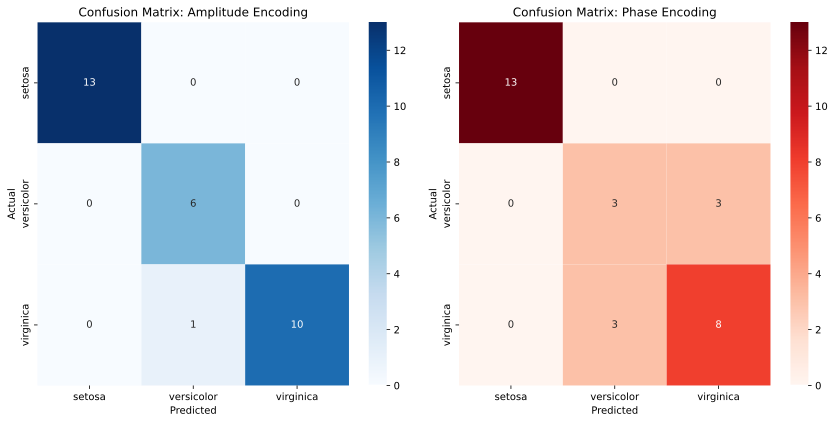

In [85]:
# Crear una matriz de confusión
conf_matrix_amp = confusion_matrix(y_test, result_amp)
conf_matrix_phase = confusion_matrix(y_test, result_phase)

# Mostrar la matriz de confusión utilizando seaborn y matplotlib
plt.figure(figsize=(12, 6))
# Gráfico 1: Matriz de confusión amplitud
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_amp, annot=True, fmt="d", cmap="Blues", xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Amplitude Encoding')

# Gráfico 2: Matriz de confusión por fase
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_phase, annot=True, fmt="d", cmap="Reds", xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Phase Encoding')

plt.tight_layout()
plt.show()

### Gráfica de puntos para la comparación de cada dato

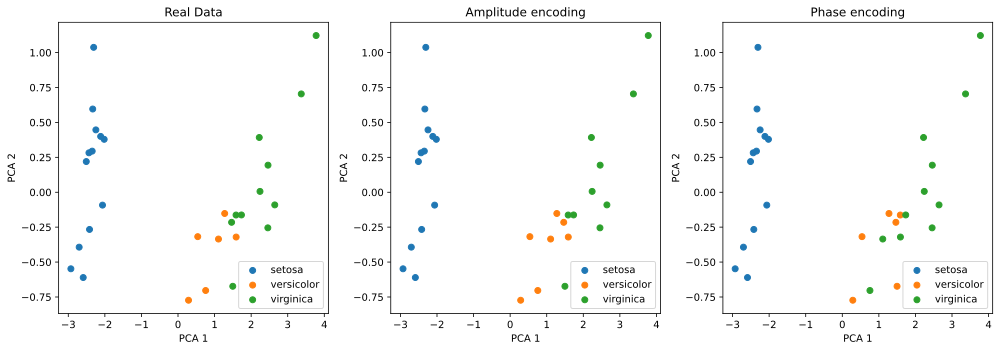

In [88]:
plt.figure(figsize=(14, 5))

test_pca = pca.fit_transform(x_test)

# Gráfico 1: Datos reales
plt.subplot(1, 3, 1)
for i in range(3):
    plt.scatter(test_pca[y_test == i,0], test_pca[y_test == i,1], label=iris.target_names[i])
plt.title('Real Data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

# Gráfico 2: Datos predichos
plt.subplot(1, 3, 2)
for i in range(3):
    plt.scatter(test_pca[result_amp == i,0], test_pca[result_amp == i,1], label=iris.target_names[i])
plt.title('Amplitude encoding')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

# Gráfico 3: Datos predichos
plt.subplot(1, 3, 3)
for i in range(3):
    plt.scatter(test_pca[result_phase == i,0], test_pca[result_phase == i,1], label=iris.target_names[i])
plt.title('Phase encoding')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusiones y resultados
Exponemos las conclusiones y resultados derivados de la evaluación del modelo de aprendizaje automático cuántico basado en el Support Vector Machine (SVM) en el contexto de la codificación de datos clásicos a datos cuánticos. Se llevaron a cabo dos abordajes de codificación: uno basado en la codificación en amplitud y otro en la codificación por desplazamiento de fase. Los resultados se cimientan en un análisis profundo de las métricas de evaluación, la matriz de confusión y la interpretación visual de las predicciones generadas por los modelos cuánticos.

La evaluación del rendimiento del modelo cuántico involucra dos enfoques distintos de codificación de datos: la codificación en amplitud y la codificación por desplazamiento de fase. Al emplear la codificación en amplitud, el modelo cuántico basado en SVM logra una eficacia del 96%. Este resultado subraya la habilidad del modelo para efectuar predicciones precisas y fiables, aprovechando la información codificada en forma de amplitudes cuánticas.

Por otro lado, al implementar la codificación por desplazamiento de fase, el modelo cuántico alcanza una eficacia del 80%. Aunque marginalmente inferior al resultado obtenido mediante la codificación en amplitud, esta cifra sigue siendo notoriamente alta, lo que insinúa la viabilidad de esta técnica de codificación en escenarios prácticos.

### Referencias
 * **scikit-learn (sklearn):**
Referencia: Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Vanderplas, J. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12(Oct), 2825-2830.
DOI: 10.5555/1953048.2078195
Página oficial: Scikit-learn

* **NumPy:**
Referencia: Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... & Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357-362.
DOI: 10.1038/s41586-020-2649-2
Página oficial: NumPy

* **Matplotlib:**
Referencia: Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90-95.
DOI: 10.1109/MCSE.2007.55
Página oficial: Matplotlib

* **Seaborn:**
Referencia: Waskom, M. (2021). Seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021.
DOI: 10.21105/joss.03021
Página oficial: Seaborn

* **Qiskit:**
Referencia: Abraham, H., Svore, K. M., & Williams, C. P. (2019). Qiskit: An open-source framework for quantum computing. arXiv preprint arXiv:1909.05820.
ArXiv: 1909.05820
Página oficial: Qiskit